# PMU Fraud detection - Data exploration

In [1]:
import pandas as pd
import fastparquet
import pyarrow
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd

# To ignore the seaborn warnings
warnings.filterwarnings('ignore')

In [2]:
# Load DataFrame 
fraud = pd.read_parquet(
    "s3a://graal-demo-data-integration/output/fraud.parquet",
    storage_options={
        "key": "REPLACE_BY_BUCKET_KEY",
        "secret": "REPLACE_BY_BUCKET_SECRET",
        "client_kwargs": {
            "endpoint_url": "https://s3.fr-par.scw.cloud",
            "region_name": "fr-par",
        },
    },
)

print(f'Dim: {fraud.shape}\n\nGeneric information:')
fraud.info()
print("\n\nObject columns statistics:")
print(fraud.describe(include=['object']))
print('\n\n5 first lines')
fraud.head(5)

Dim: (1215, 11)

Generic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CN                    1215 non-null   Int64 
 1   date                  1215 non-null   object
 2   amount                1215 non-null   Int64 
 3   ip                    1215 non-null   object
 4   ip_range              1215 non-null   object
 5   is_valid              1215 non-null   bool  
 6   provider              1215 non-null   object
 7   country_name          1215 non-null   object
 8   continent_code        564 non-null    object
 9   continent_name        1215 non-null   object
 10  is_in_european_union  1215 non-null   Int64 
dtypes: Int64(3), bool(1), object(7)
memory usage: 99.8+ KB


Object columns statistics:
              date             ip    ip_range  provider   country_name  \
count         1215           1215        1

,CN,date,amount,ip,ip_range,is_valid,provider,country_name,continent_code,continent_name,is_in_european_union
0,30001034549321,2022-02-01,13595,6.200.204.63,6.0.0.0/8,True,ExpressVPN,United States,None,North America,0
1,30001034549321,2022-02-01,13595,6.200.204.63,6.0.0.0/8,True,KeepSolid VPN Unlimited,United States,None,North America,0
2,30001034549321,2022-02-01,13595,6.200.204.63,6.0.0.0/8,True,PureVPN,United States,None,North America,0
3,30001034549321,2022-02-01,13595,6.200.204.63,6.0.0.0/8,True,SaferVPN,United States,None,North America,0
4,30001034549321,2022-02-01,13595,6.200.204.63,6.0.0.0/8,True,TunnelBear,United States,None,North America,0


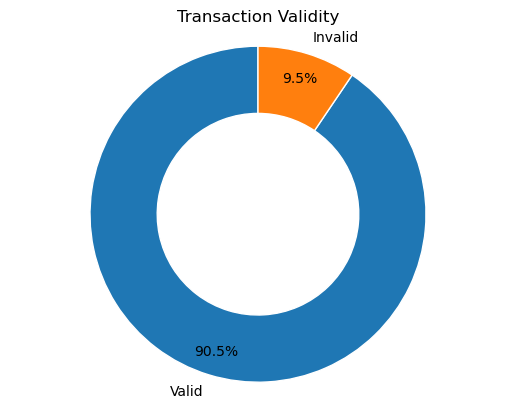

In [3]:
# Calculate the percentage of valid and invalid transactions
valid_percentage = (fraud['is_valid'] == True).mean() * 100
invalid_percentage = 100 - valid_percentage

# Create a donut plot
fig, ax = plt.subplots()
ax.pie([valid_percentage, invalid_percentage], labels=['Valid', 'Invalid'], autopct='%1.1f%%',
       startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a circle in the center to make it a donut plot
center_circle = plt.Circle((0, 0), 0.50, fc='white')
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Transaction Validity')

# Show the plot
plt.show()

This graph highlights the unbalance of our dataset. Indeed, because the majority of money transactions are valid, we may need to rebalance our data.

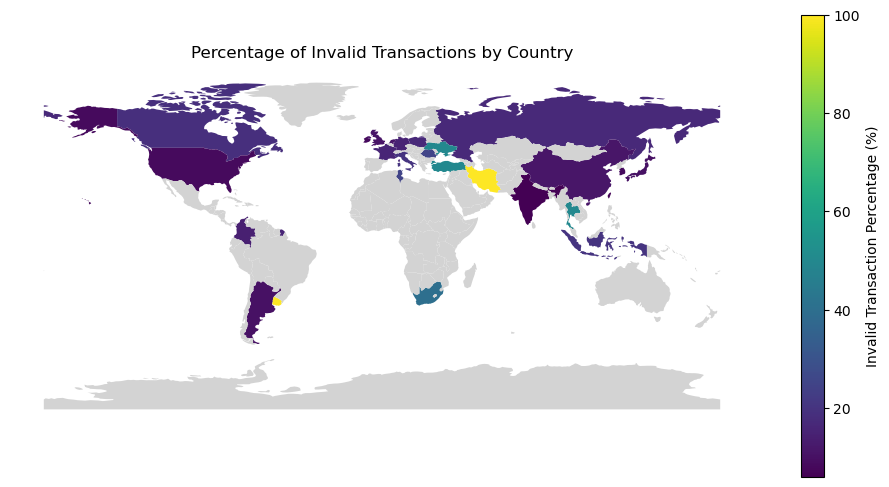

In [4]:
# Read the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Calculate the percentage of invalid transactions per country
total_transactions_by_country = fraud.groupby(["country_name"]).size().reset_index(name='total_counts')
invalid_transactions_by_country = fraud[fraud["is_valid"] == False].groupby(["country_name"]).size().reset_index(name='invalid_counts')

# Merge the data with the world map data, keeping all countries
world["name"] = world["name"].str.replace("United States of America", "United States")
merged_data = world.merge(total_transactions_by_country, left_on='name', right_on='country_name', how='left')
merged_data = merged_data.merge(invalid_transactions_by_country, left_on='name', right_on='country_name', how='left')

# Calculate the percentage of invalid transactions
merged_data['invalid_percentage'] = (merged_data['invalid_counts'] / merged_data['total_counts']) * 100

# Create the subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot the choropleth map for Invalid Transaction Percentage
merged_data.plot(column='invalid_percentage', cmap='viridis', legend=True, ax=ax, legend_kwds={'label': "Invalid Transaction Percentage (%)"}, missing_kwds={'color': 'lightgrey'})

# Set the axis off to remove map axes
ax.axis('off')

# Set the title
ax.set_title('Percentage of Invalid Transactions by Country')

# Show the plot
plt.show()

As we can see, Iran and Urguay clearly stand out from the other countries with their invalid transactions percentage reaching almost 100%. However, crossing this graph with the following, we can also say that despite of their number of transactions, countries such as USA or China do have a particularly low rate of invalid ones.

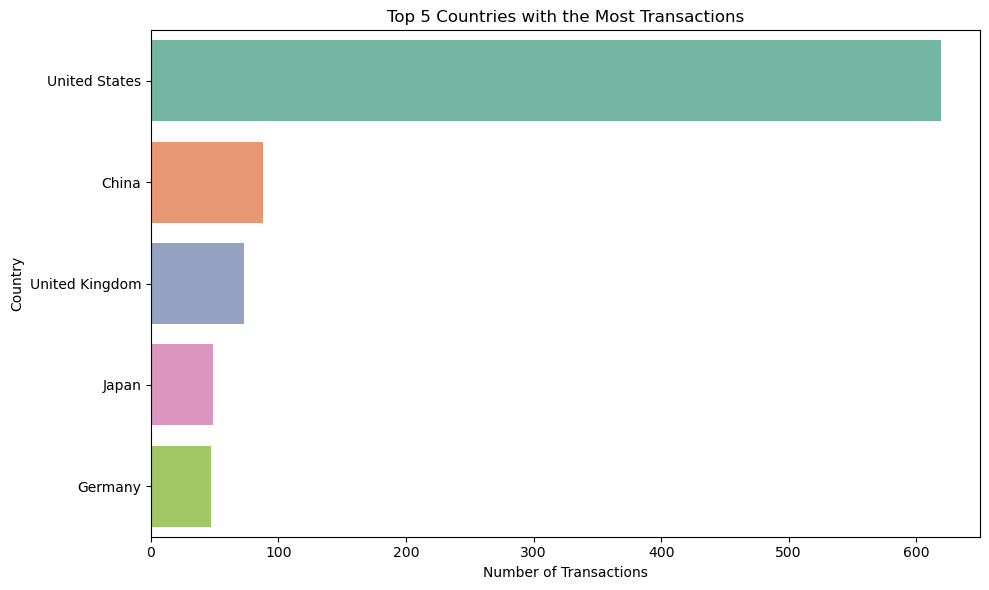

In [5]:
# Calculate the total number of transactions per country
transactions_by_country = fraud.groupby(["country_name"]).size()

# Get the top 5 countries with the most transactions
top_countries = transactions_by_country.nlargest(5)

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='Set2')

# Set the title and labels
plt.title("Top 5 Countries with the Most Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")

# Show the plot
plt.tight_layout()
plt.show()

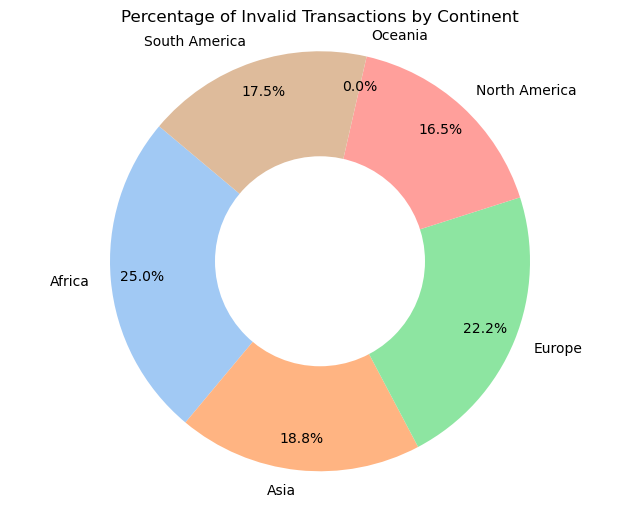

In [6]:
# Calculate the percentages
fraud_invalid = fraud[fraud["is_valid"] == False]
transactions_by_continent = fraud.groupby(["continent_name"]).size()
fraud_by_continent = fraud_invalid.groupby(["continent_name"]).size()
percentage_invalid_by_continent = fraud_by_continent / transactions_by_continent
percentage_invalid_by_continent['Oceania'] = 0

# Create a donut chart
plt.figure(figsize=(8, 6))
plt.pie(percentage_invalid_by_continent, labels=percentage_invalid_by_continent.index,
        autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=sns.color_palette('pastel'))

# Draw a circle in the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Invalid Transactions by Continent')
plt.axis('equal')
plt.show()


Nous remarquons que à part l'Oceanie qui affiche 0% de taux de fraud, les autres continents ont un taux assez similaire. 

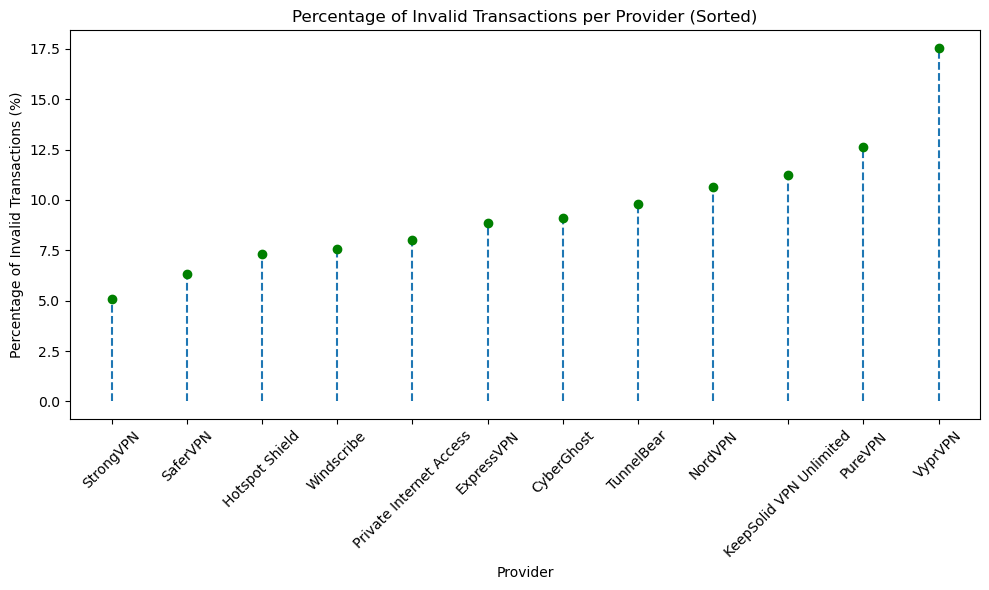

In [7]:
# Calculate the percentage of invalid transactions per provider
transactions_by_provider = fraud.groupby(["provider"]).size()
fraud_invalid = fraud[fraud["is_valid"] == False]
fraud_by_provider = fraud_invalid.groupby(["provider"]).size()

percentage_invalid_by_provider = (fraud_by_provider / transactions_by_provider) * 100

# Sort the data by percentage (from lowest to highest)
percentage_invalid_by_provider = percentage_invalid_by_provider.sort_values()

# Create a lollipop chart with orange markers and blue lines
plt.figure(figsize=(10, 6))
plt.stem(percentage_invalid_by_provider.index, percentage_invalid_by_provider.values, markerfmt='go', linefmt='--', basefmt=' ')

# Set the title and labels
plt.title("Percentage of Invalid Transactions per Provider (Sorted)")
plt.xlabel("Provider")
plt.ylabel("Percentage of Invalid Transactions (%)")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

The provider **VypVPN** presents the highest number of invalid transactions compared to its total amount of transactions (17,5%). On the opposite, the provider **StrongVPN** has the lowest rate. 

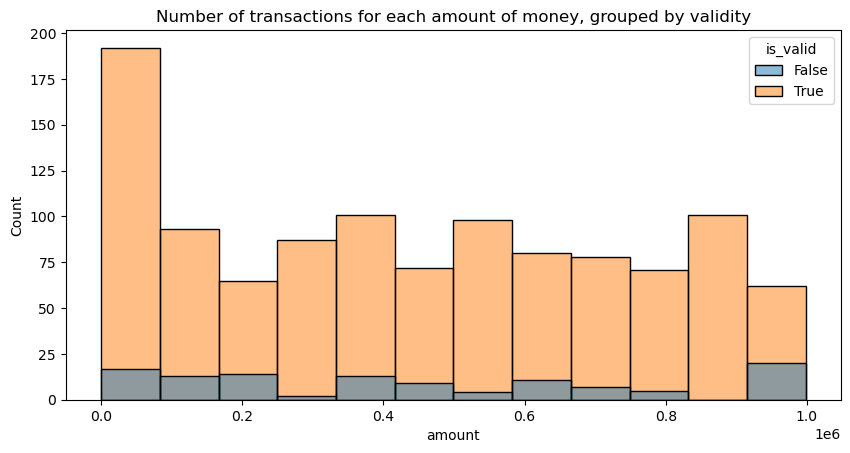

In [8]:
figure_5 = plt.figure().set_figwidth(10)
plt.title("Number of transactions for each amount of money, grouped by validity")
figure_5 = sns.histplot(data=fraud, x='amount', hue='is_valid')

While the *valid/invalid* transactions ratio seems to be quite constant for all other amounts, we clearly observe a higher one for the transactions over 900,000$, reaching almost **30%.

In [9]:
# Change the time of the date column to datetime
fraud["date"] = pd.to_datetime(fraud["date"])

# Count the number of valid an invalid transaction for each date 
fraud_by_date = fraud.groupby(["date","is_valid"]).size().reset_index(name='counts')

print(f'Dim: {fraud_by_date.shape}\n\nGeneric information:')
fraud_by_date.info()
print('\n\n5 first lines')
fraud_by_date.head(5)

Dim: (457, 3)

Generic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      457 non-null    datetime64[ns]
 1   is_valid  457 non-null    bool          
 2   counts    457 non-null    int64         
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 7.7 KB


5 first lines


,date,is_valid,counts
0,2022-01-01,True,1
1,2022-01-02,True,3
2,2022-01-03,True,9
3,2022-01-04,True,2
4,2022-01-05,True,4


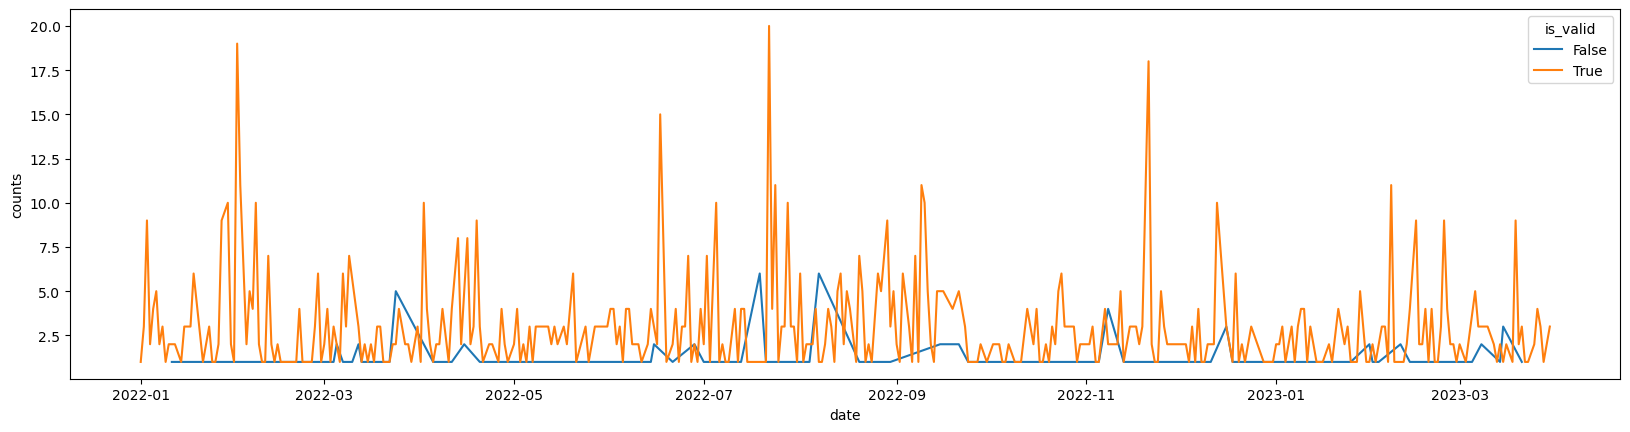

In [10]:
# Plot the number of valid and invalid transactions depending on the date 
figure = plt.figure().set_figwidth(20)
figure = sns.lineplot(data=fraud_by_date, x='date', y='counts', hue='is_valid')

There doesn't seem to be a clear pattern of invalid transactions over time.